In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
from dagshub import init
from dotenv import load_dotenv
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical,Real,Integer
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score

c:\Users\akhde\OneDrive\Desktop\MLOps\Income-Prediction-app\.venv\Lib\site-packages\mlflow\protos\service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service
c:\Users\akhde\OneDrive\Desktop\MLOps\Income-Prediction-app\.venv\Lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [3]:
os.chdir('../')

In [4]:
df = pd.read_csv('data/adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
df.shape


(48842, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
df.replace('?',np.nan,inplace=True)

In [8]:
df.isnull().mean()*100

age                0.000000
workclass          5.730724
fnlwgt             0.000000
education          0.000000
educational-num    0.000000
marital-status     0.000000
occupation         5.751198
relationship       0.000000
race               0.000000
gender             0.000000
capital-gain       0.000000
capital-loss       0.000000
hours-per-week     0.000000
native-country     1.754637
income             0.000000
dtype: float64

In [9]:
nan = df.isnull().mean()*100
nan_cols = nan[nan>0].index.tolist()
def inpute_nan(df,variable):
    df[variable].fillna(df[variable].value_counts().index[0],inplace=True)

nan_var = ['workclass','occupation','native-country']
for var in nan_cols:
    inpute_nan(df,var)

C:\Users\akhde\AppData\Local\Temp\ipykernel_21052\243742547.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[variable].fillna(df[variable].value_counts().index[0],inplace=True)
C:\Users\akhde\AppData\Local\Temp\ipykernel_21052\243742547.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

<Axes: xlabel='income', ylabel='age'>

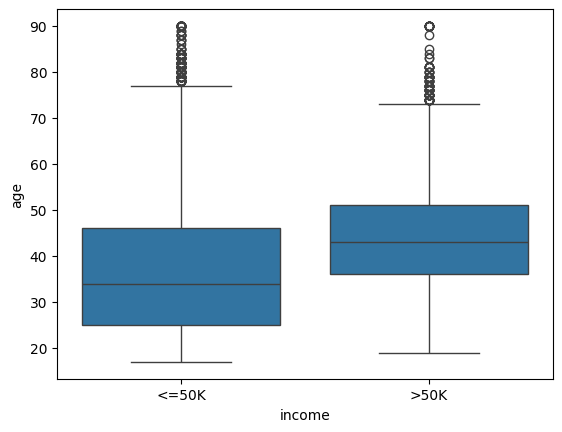

In [10]:
sns.boxplot(x='income',y='age',data=df)

<Axes: xlabel='income', ylabel='hours-per-week'>

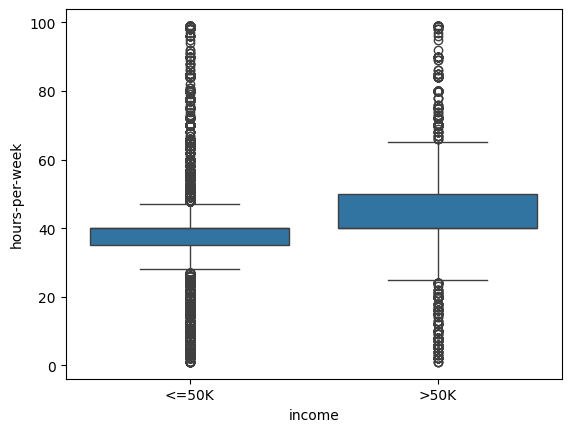

In [11]:
sns.boxplot(x='income',y='hours-per-week',data=df)

In [12]:
age_0 = df[df['income']=='<=50K'].age
age_1 = df[df['income']=='>50K'].age

def detect_outliers(lt):
    iqr= lt.quantile(0.75)-lt.quantile(0.25)
    ub = lt.quantile(0.75)+1.5*iqr
    lb=lt.quantile(0.25)-1.5*iqr
    upper_array = lt.loc[lt > ub]
    lower_array = lt.loc[lt < lb]
    return upper_array,lower_array

age_0_upper,age_0_lower = detect_outliers(age_0)
age_1_upper,age_1_lower = detect_outliers(age_1)

df = df.drop(age_0_upper.index)
df = df.drop(age_0_lower.index)
df = df.drop(age_1_upper.index)
df = df.drop(age_1_lower.index)


In [13]:
hours_0 = df.loc[df['income']=='<=50K','hours-per-week']
hours_1 = df.loc[df['income']=='>50K','hours-per-week']

hours_1_upper,hours_1_lower = detect_outliers(hours_1)
hours_0_upper,hours_0_lower = detect_outliers(hours_0)

df = df.drop(hours_0_upper.index)
df = df.drop(hours_0_lower.index)
df = df.drop(hours_1_upper.index)
df = df.drop(hours_1_lower.index)

<Axes: xlabel='workclass', ylabel='count'>

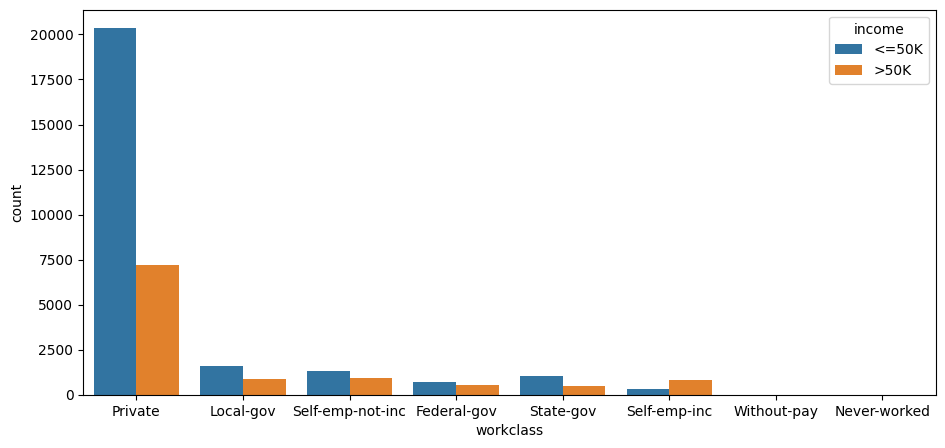

In [14]:
plt.figure(figsize=(11,5))
sns.countplot(x='workclass',hue='income',data=df)

<Figure size 1000x500 with 0 Axes>

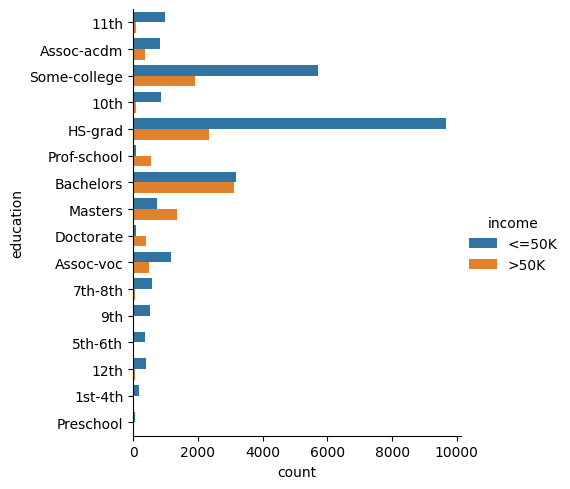

In [15]:
plt.figure(figsize=(10,5 ))
sns.catplot(y='education',hue='income',kind='count',data=df)

<Axes: xlabel='gender', ylabel='count'>

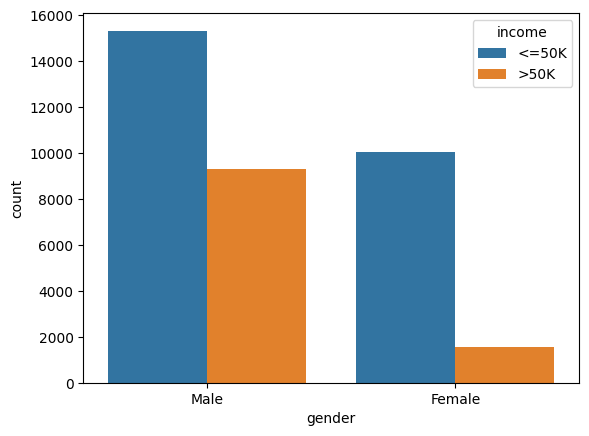

In [16]:
sns.countplot(x='gender',hue='income',data=df)

<Axes: xlabel='count', ylabel='marital-status'>

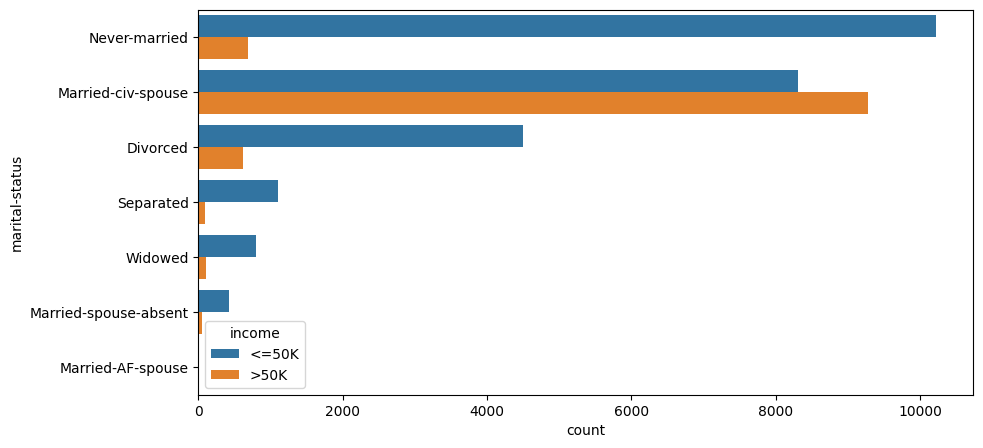

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(y='marital-status',hue='income',data=df)

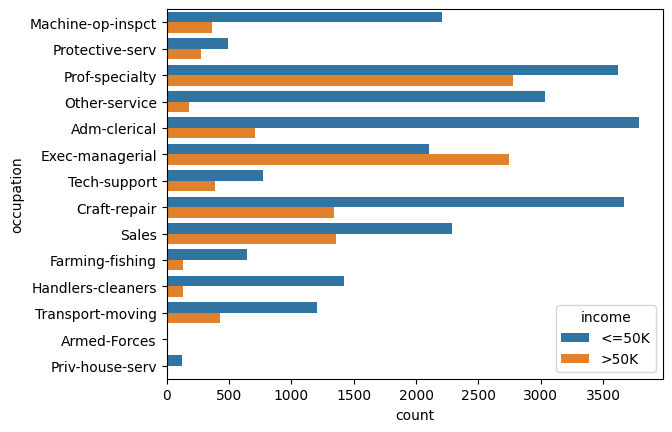

In [18]:
sns.countplot(y="occupation", hue="income",data=df);


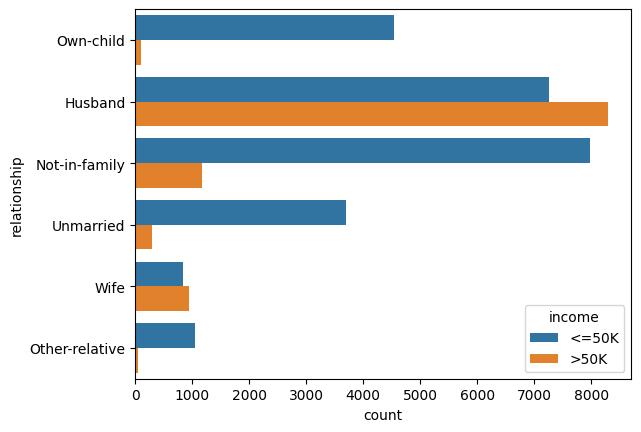

In [19]:
sns.countplot(y="relationship", hue="income",data=df);


<Figure size 2000x700 with 0 Axes>

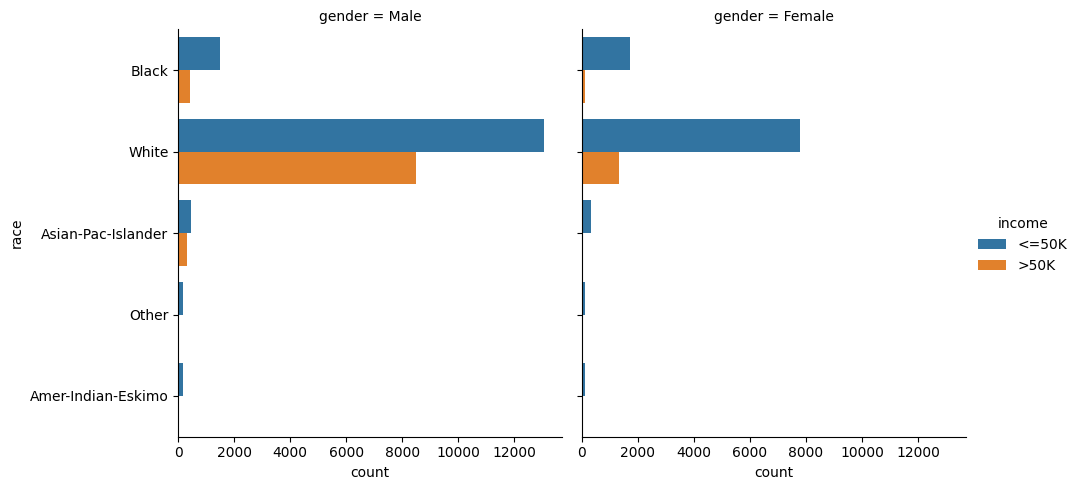

In [20]:
plt.figure(figsize=(20,7))
sns.catplot(y="race", hue="income", kind="count",col="gender", data=df);

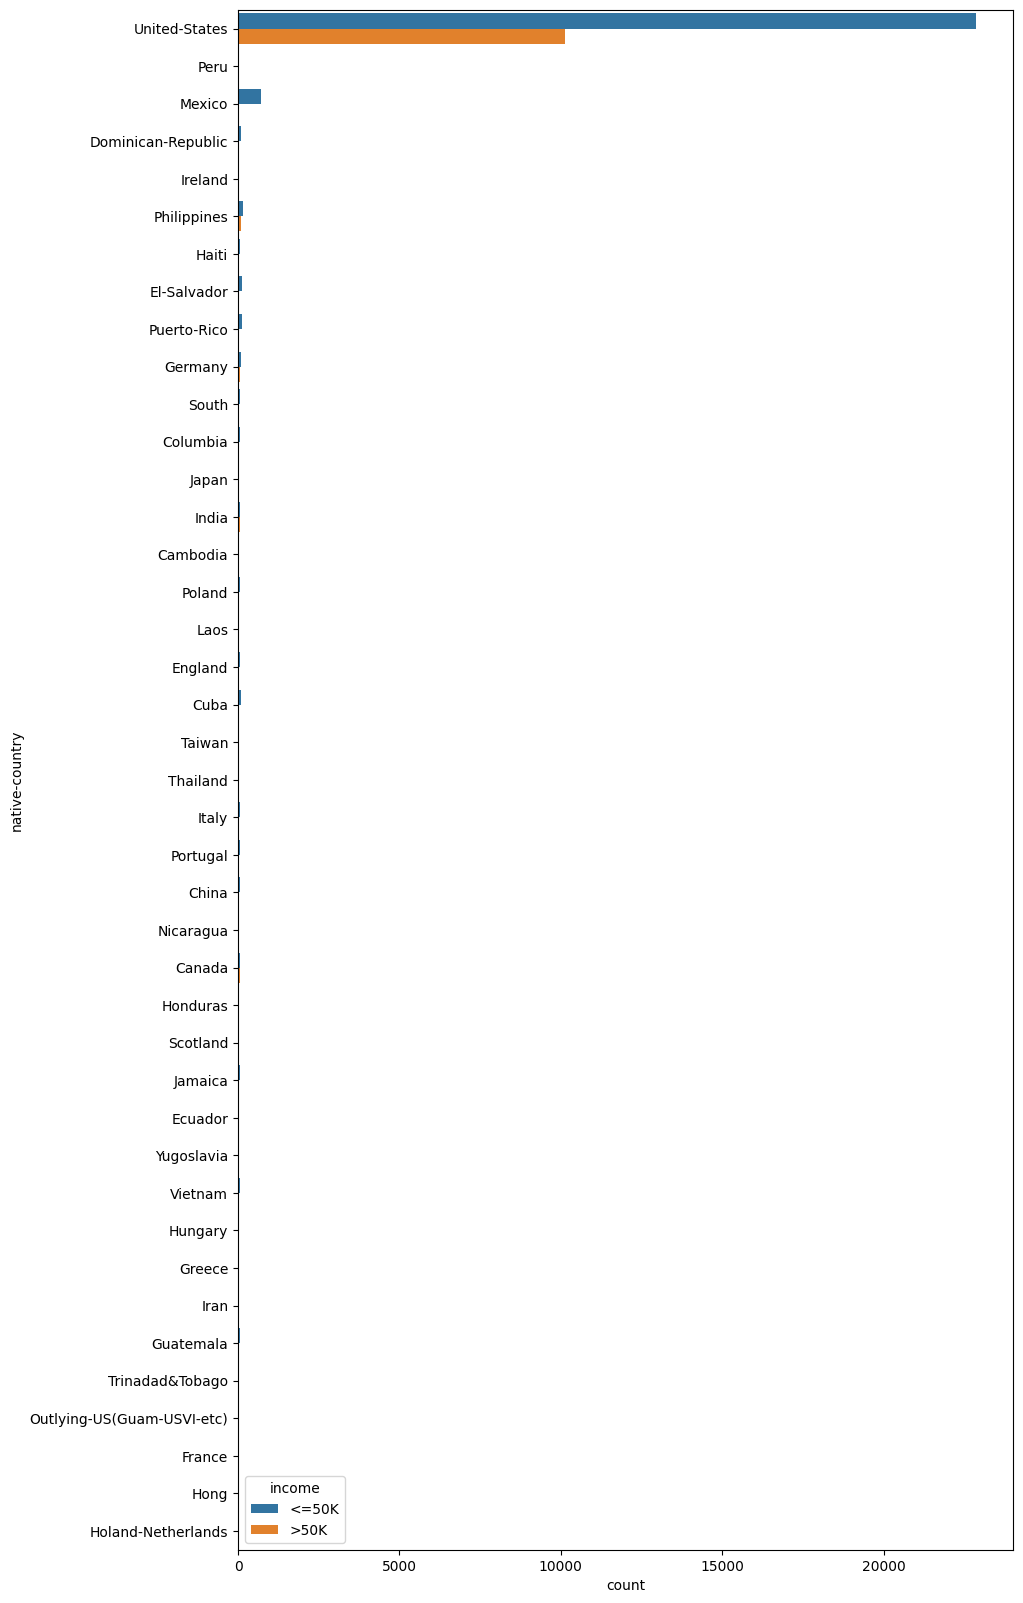

In [21]:
plt.figure(figsize=(10,20))
sns.countplot(y="native-country", hue="income", data=df);

<Axes: xlabel='capital-gain', ylabel='Count'>

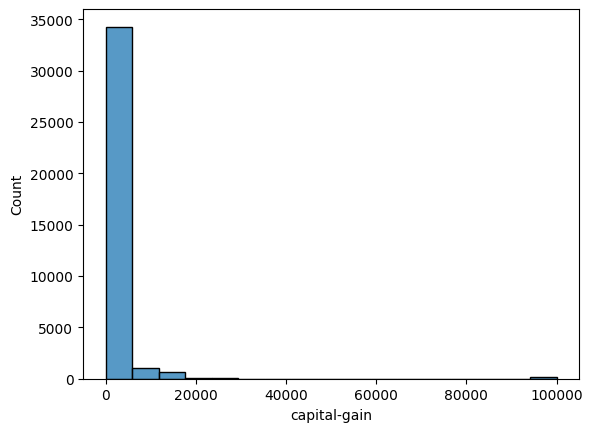

In [22]:
sns.histplot(x='capital-gain',data=df)


<Axes: xlabel='capital-loss', ylabel='Count'>

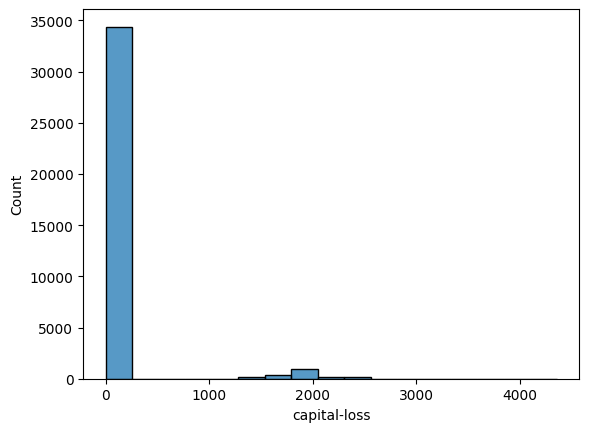

In [23]:
sns.histplot(x='capital-loss',data=df)


In [24]:
dt = df.dtypes
obj_col = dt[dt=='object'].index.tolist()
for col in obj_col:
    print(f'\n{col} -> {df[col].unique()}')


workclass -> ['Private' 'Local-gov' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

education -> ['11th' 'Assoc-acdm' 'Some-college' '10th' 'HS-grad' 'Prof-school'
 'Bachelors' 'Masters' 'Doctorate' 'Assoc-voc' '7th-8th' '9th' '5th-6th'
 '12th' '1st-4th' 'Preschool']

marital-status -> ['Never-married' 'Married-civ-spouse' 'Divorced' 'Separated' 'Widowed'
 'Married-spouse-absent' 'Married-AF-spouse']

occupation -> ['Machine-op-inspct' 'Protective-serv' 'Prof-specialty' 'Other-service'
 'Adm-clerical' 'Exec-managerial' 'Tech-support' 'Craft-repair' 'Sales'
 'Farming-fishing' 'Handlers-cleaners' 'Transport-moving' 'Armed-Forces'
 'Priv-house-serv']

relationship -> ['Own-child' 'Husband' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']

race -> ['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']

gender -> ['Male' 'Female']

native-country -> ['United-States' 'Peru' 'Mexico' 'Dominican-Republic' 'Ireland'
 'Philippines' 'H

In [25]:
df["work_type"] = df["workclass"].replace({
    "Self-emp-not-inc": "Self-Employed",
    "Self-emp-inc": "Self-Employed",
    "Local-gov" : "Gov_employee",
    "State_gov" : "Gov_employee",
    "Without-pay": "Other",
    "Never-worked": "Other"
})

df["is_married"] = df["marital-status"].apply(lambda x: 1 if "Married" in x else 0)

def group_country(country):
    if country in ['United-States','Mexico','Canada']:
        return 'North America'
    elif country in ['India', 'China', 'Philippines', 'Japan','Taiwan','Iran']:
        return 'Asia'
    elif country in ['Germany', 'England', 'France', 'Italy','Poland']:
        return 'Europe'
    else:
        return 'Other'

df['region'] = df['native-country'].apply(group_country)
df["race_gender"] = df["race"] + "_" + df["gender"]

df["has_capital_gain"] = (df["capital-gain"] > 0).astype(int)
df["has_capital_loss"] = (df["capital-loss"] > 0).astype(int)

In [26]:
df = df.drop('fnlwgt',axis=1)
df['income'] = df['income'].map({'>50K':1, '<=50K':0})


In [27]:
df = df.drop(columns=['race','gender','native-country','marital-status','workclass'],axis=1)

In [28]:
df = df.drop('education',axis=1)

In [39]:
df.shape

(36216, 14)

In [62]:
X = df.drop('income',axis=1)
y = df.loc[:,'income']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=True)

In [63]:
X_test.shape

(5433, 13)

In [74]:
df_dtypes = X_train.dtypes
obj_cols = df_dtypes[df_dtypes == 'object'].index.tolist()
num_cols = df_dtypes[df_dtypes != 'object'].index.tolist()

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler',StandardScaler(),num_cols),
        ('cat',oe,obj_cols),
    ]
)

In [75]:
df_dtypes[df_dtypes != 'object'].index.tolist()

['age',
 'educational-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'is_married',
 'has_capital_gain',
 'has_capital_loss']

In [76]:
pipeline = Pipeline(steps=[
    ('preprocess',preprocessor),
])

X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [77]:
X_train_processed.shape

(30783, 13)

In [78]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

In [79]:
load_dotenv()
tracking_uri = os.getenv('MLFLOW_TRACKING_URI')
repo_name = os.getenv('DAGSHUB_REPO_NAME')
repo_owner = os.getenv('DAGSHUB_REPO_OWNER')
mlflow.set_tracking_uri(tracking_uri)
init(repo_name=repo_name,repo_owner=repo_owner,mlflow=True)
mlflow.set_experiment('Notebook_Experiments')

Initialized MLflow to track repo "AkHiLdEvGoD/Income-Prediction-app"

Repository AkHiLdEvGoD/Income-Prediction-app initialized!

<Experiment: artifact_location='mlflow-artifacts:/e29d8acdae6f4fec9892e970e5ced806', creation_time=1755357798321, experiment_id='0', last_update_time=1755357798321, lifecycle_stage='active', name='Notebook_Experiments', tags={}>

In [80]:
models_with_search_space = {
    'logistic_regression' : {
        'model' : LogisticRegression(),
        'search_space' : {
            'classifier__solver': Categorical(['liblinear','saga']),
            'classifier__penalty': Categorical(['l1', 'l2']),
            'classifier__C': Real(0.01,10,prior='log-uniform')
        }
    },
    'KNN' : {
        'model' : KNeighborsClassifier(),
        'search_space' : {
            'classifier__n_neighbors': Integer(1,10),
            'classifier__weights': Categorical(['uniform', 'distance']),
            'classifier__metric': Categorical(['euclidean', 'manhattan']),
        } 
    }
}

for name,config in models_with_search_space.items():
    pipe = Pipeline([
        ('classifier',config['model'])
    ])
    opt = BayesSearchCV(
        estimator=pipe,
        search_spaces=config['search_space'],
        n_iter=25,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    with mlflow.start_run(run_name=f'{name}') as parent:
        opt.fit(X_train_resampled, y_train_resampled)

        for i in range(len(opt.cv_results_['params'])):
            with mlflow.start_run(nested=True) as child:
                mlflow.log_params(opt.cv_results_['params'][i])
                mlflow.log_metric('accuracy', opt.cv_results_['mean_test_score'][i])

        mlflow.log_param('Algorithm', name)
        mlflow.log_params(opt.best_params_)

        y_pred = opt.predict(X_test_processed)
        metrics = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred),
                    'recall': recall_score(y_test, y_pred),
                    'f1_score': f1_score(y_test, y_pred)
                }

        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(opt.best_estimator_,artifact_path=name)
        mlflow.set_tag('Author', 'Akhil')

    print(f"\n{name}:\nBest Params: {opt.best_params_}\nBest Accuracy: {opt.best_score_}\n {opt.best_estimator_}")


2025/08/17 01:49:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



logistic_regression:
Best Params: OrderedDict({'classifier__C': 0.3142592889252027, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'})
Best Accuracy: 0.8425202145002407
 Pipeline(steps=[('classifier',
                 LogisticRegression(C=0.3142592889252027, solver='saga'))])


2025/08/17 01:52:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



KNN:
Best Params: OrderedDict({'classifier__metric': 'manhattan', 'classifier__n_neighbors': 6, 'classifier__weights': 'distance'})
Best Accuracy: 0.8788197157078267
 Pipeline(steps=[('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=6,
                                      weights='distance'))])
